In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision import models
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import os
import nibabel as nib
import torch.nn.functional as F
import seaborn as sns
from models.unet import UNet
from datasets.BRATS2018 import NormalizeBRATS, ToTensor

%matplotlib inline

In [2]:
def visualize(model_path, device, base_path, img_name):
    """
    Plot the original image, predicted dense labels and the ground-true labels.
    Parameters:
    - model: PyTorch model
    - base_path: path to the augmented Pascal VOC dataset
    - img_name: image file name without format extension
                e.g. 2008_000073 is the img_path for 2008_000073.jpg and 2008_000073.mat
    """
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 20))
    brats_colors = [[0, 0, 0], [192, 132, 0], [132, 0, 192], [0, 192, 132]]
    brats_classes = ['background', 'necrotic tumor', 'peritumoral edema', 'enhancing tumor']
    
    scan_path = os.path.join(base_path, img_name + '_scan.npy')
    gt_path = os.path.join(base_path, img_name + '_seg.npy')
    
    ind2color = {}
    legend_elements = []
    for ind, color in enumerate(brats_colors):
        ind2color[ind] = (color, brats_classes[ind])
        legend_elements.append(Line2D([0], [0], color=np.array(color)/255, lw=6))
    
    ax1.set_title('original image')
    sc = np.load(scan_path)
    gt = np.load(gt_path)
    assert sc.shape == (4, 240, 240)
    assert gt.shape == (240, 240)
    ax1.imshow(sc[1])
    
    model = UNet(4, 4, residual=True, expansion=2)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    
    normalize_brats = NormalizeBRATS()
    to_tensor = ToTensor()
    
    sc, gt = normalize_brats((sc, gt))
    sc, gt = to_tensor((sc, gt))
    
    sc = sc.to(device)
    gt = gt.to(device)
    
    # unsqueeze to 4 dimension NxCxHxW
    sc = torch.unsqueeze(sc, dim=0)
    with torch.no_grad():
        output = model(sc)
        pred = torch.argmax(F.softmax(output, dim=1), dim=1, keepdim=True)
    
    # squeeze back to 2 dimension HxW
    pred = torch.squeeze(pred)
    
    gt = gt.cpu().numpy()
    pred = pred.cpu().numpy()
    
    height, width = pred.shape
    colored_pred = np.zeros((height, width, 3), dtype=np.uint8)
    for h in range(height):
        for w in range(width):
            colored_pred[h, w] = ind2color[pred[h, w]][0]
            
    ax2.set_title('predicted feature map')
    ax2.imshow(colored_pred)
    
    height, width = gt.shape
    colored_gt = np.zeros((height, width, 3), dtype=np.uint8)
    for h in range(height):
        for w in range(width):
            colored_gt[h, w] = ind2color[gt[h, w]][0]
    
    ax3.set_title('ground true dense label')
    ax3.legend(handles=legend_elements, labels=brats_classes, loc='upper center', bbox_to_anchor=(1.5, 1.2))
    ax3.imshow(colored_gt)
    
    # release GPU memory
    del model
    del output
    del sc
    torch.cuda.empty_cache()

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## End-to-End segmentation for HGG cases

The code block below demonstrates the segmentation for an axial plane (slice) of a single HGG case. The case name - 'Brats18_TCIA06_603_1_073' indicates the case ID of this 3D MRI scan - 'Brats18_TCIA06_603_1' and the index of this slice - '73'.

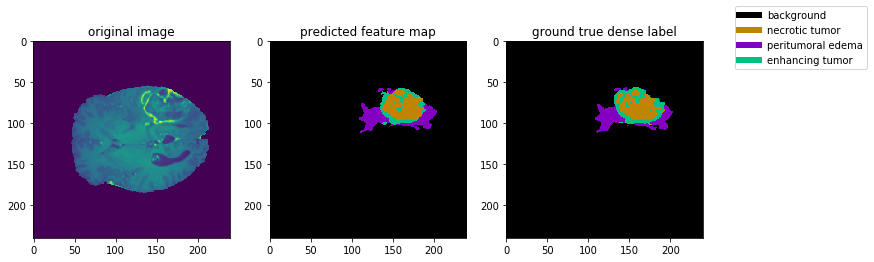

In [78]:
visualize(model_path='../UNet-ResidualBlock-Expansion_210_end_to_end_manual/UNet-ResidualBlock-Expansion-BRATS2018-End-to-End_batch6_training_epochs15_Adam_scheduler-step10-gamma1.0_lr5e-05_w_decay3e-05/trained_model.pt',
         device=device, base_path='BRATS2018/SEG_HGG/val/', img_name='Brats18_TCIA06_603_1_073')
torch.cuda.empty_cache()

The following cells show a series of 2D segmentations of the same 3D MRI scan. In general, peritumoral edema is the biggest sub-region among all of foregrounds. And intuitively, it's also the easiest part to segment. Corresponding to the 3D visualization before, in most cases, the region of necrotic tumor gets encompassed by enhancing tumor area.

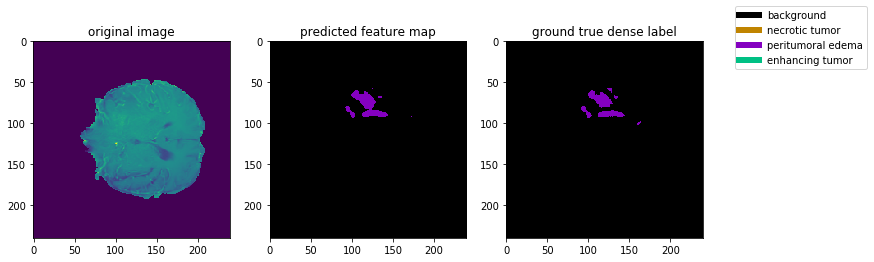

In [66]:
visualize(model_path='../UNet-ResidualBlock-Expansion_210_end_to_end_manual/UNet-ResidualBlock-Expansion-BRATS2018-End-to-End_batch6_training_epochs15_Adam_scheduler-step10-gamma1.0_lr5e-05_w_decay3e-05/trained_model.pt',
         device=device, base_path='BRATS2018/SEG_HGG/val/', img_name='Brats18_TCIA06_372_1_067')
torch.cuda.empty_cache()

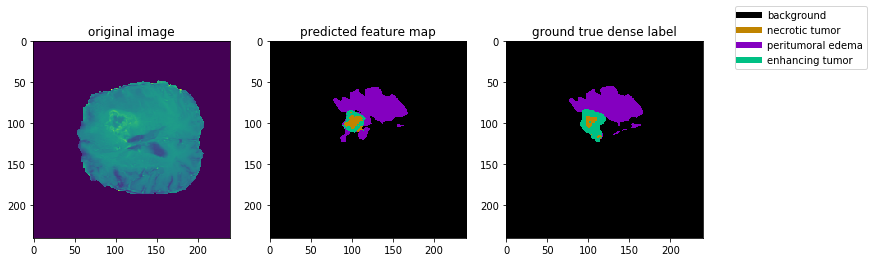

In [65]:
visualize(model_path='../UNet-ResidualBlock-Expansion_210_end_to_end_manual/UNet-ResidualBlock-Expansion-BRATS2018-End-to-End_batch6_training_epochs15_Adam_scheduler-step10-gamma1.0_lr5e-05_w_decay3e-05/trained_model.pt',
         device=device, base_path='BRATS2018/SEG_HGG/val/', img_name='Brats18_TCIA06_372_1_077')
torch.cuda.empty_cache()

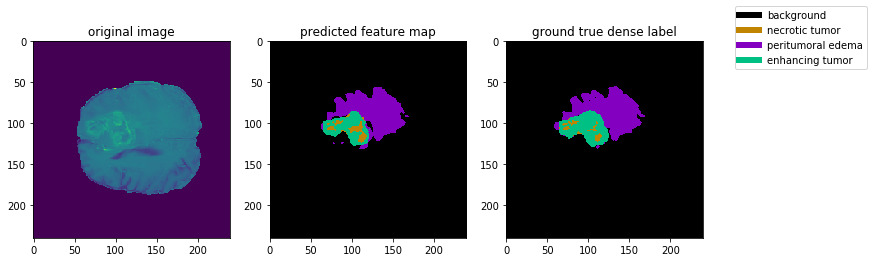

In [61]:
visualize(model_path='../UNet-ResidualBlock-Expansion_210_end_to_end_manual/UNet-ResidualBlock-Expansion-BRATS2018-End-to-End_batch6_training_epochs15_Adam_scheduler-step10-gamma1.0_lr5e-05_w_decay3e-05/trained_model.pt',
         device=device, base_path='BRATS2018/SEG_HGG/val/', img_name='Brats18_TCIA06_372_1_087')
torch.cuda.empty_cache()

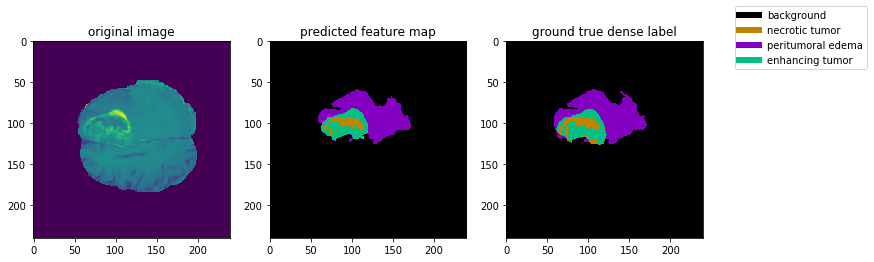

In [67]:
visualize(model_path='../UNet-ResidualBlock-Expansion_210_end_to_end_manual/UNet-ResidualBlock-Expansion-BRATS2018-End-to-End_batch6_training_epochs15_Adam_scheduler-step10-gamma1.0_lr5e-05_w_decay3e-05/trained_model.pt',
         device=device, base_path='BRATS2018/SEG_HGG/val/', img_name='Brats18_TCIA06_372_1_097')
torch.cuda.empty_cache()

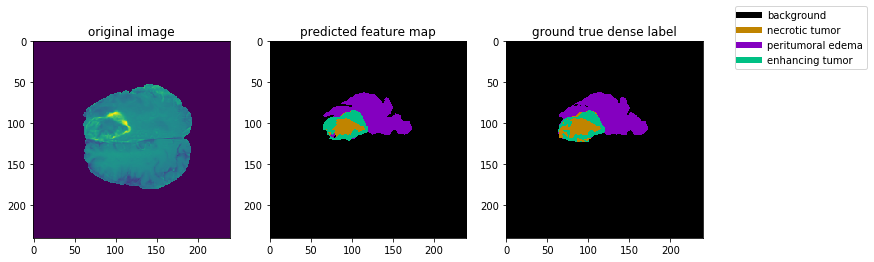

In [68]:
visualize(model_path='../UNet-ResidualBlock-Expansion_210_end_to_end_manual/UNet-ResidualBlock-Expansion-BRATS2018-End-to-End_batch6_training_epochs15_Adam_scheduler-step10-gamma1.0_lr5e-05_w_decay3e-05/trained_model.pt',
         device=device, base_path='BRATS2018/SEG_HGG/val/', img_name='Brats18_TCIA06_372_1_107')
torch.cuda.empty_cache()

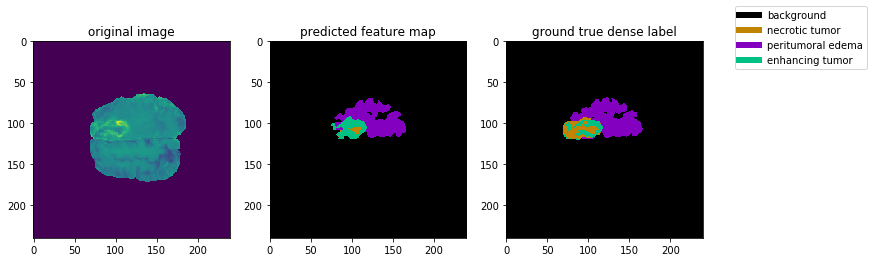

In [69]:
visualize(model_path='../UNet-ResidualBlock-Expansion_210_end_to_end_manual/UNet-ResidualBlock-Expansion-BRATS2018-End-to-End_batch6_training_epochs15_Adam_scheduler-step10-gamma1.0_lr5e-05_w_decay3e-05/trained_model.pt',
         device=device, base_path='BRATS2018/SEG_HGG/val/', img_name='Brats18_TCIA06_372_1_117')
torch.cuda.empty_cache()

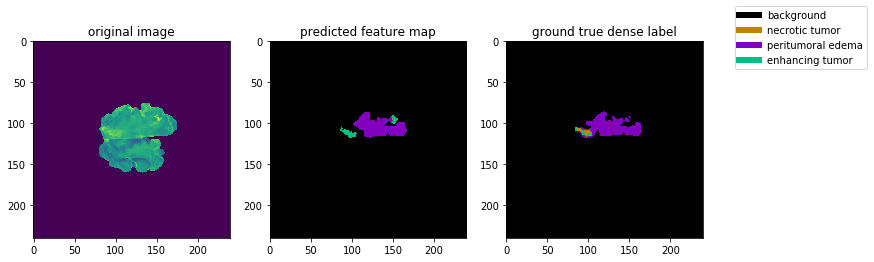

In [70]:
visualize(model_path='../UNet-ResidualBlock-Expansion_210_end_to_end_manual/UNet-ResidualBlock-Expansion-BRATS2018-End-to-End_batch6_training_epochs15_Adam_scheduler-step10-gamma1.0_lr5e-05_w_decay3e-05/trained_model.pt',
         device=device, base_path='BRATS2018/SEG_HGG/val/', img_name='Brats18_TCIA06_372_1_127')
torch.cuda.empty_cache()

# End-to-End segmentation for LGG cases

As mentioned in the paper, there are some non-negligible differences between HGG and LGG MRI scans. The following 2 cells compare the segmentation results generated by models trained on HGG and LGG scans respectively. The inference made by HGG model misses the necrotic tumor region; however, LGG model performs much better than its counterpart on LGG MRI scans. Both of two models classifies a little amount of pixels as enhancing tumor, which does not exist in the ground-true label. In order to avoid this issue, a threshold of 700 pixels is set to enhancing tumor, when processing cases in the BraTS2018 validation set.

### HGG model for LGG MRI scan

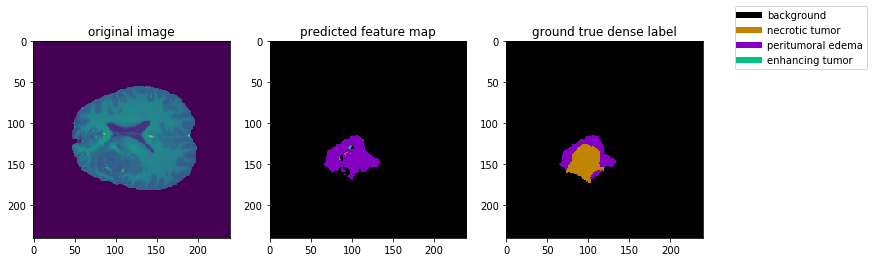

In [21]:
visualize(model_path='../UNet-ResidualBlock-Expansion_210_end_to_end_manual/UNet-ResidualBlock-Expansion-BRATS2018-End-to-End_batch6_training_epochs15_Adam_scheduler-step10-gamma1.0_lr5e-05_w_decay3e-05/trained_model.pt',
         device=device, base_path='BRATS2018/SEG_LGG/val/', img_name='Brats18_TCIA13_634_1_088')
torch.cuda.empty_cache()

### Results after the forward-pass through LGG model

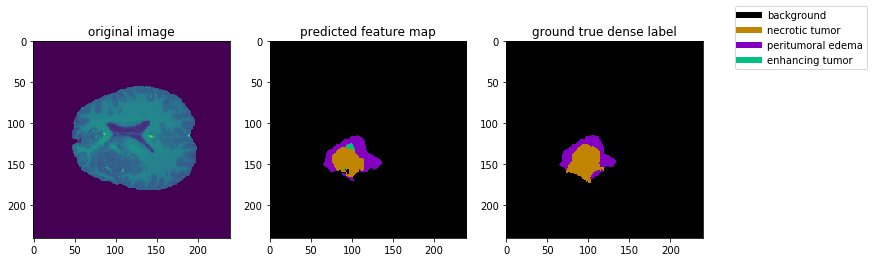

In [22]:
visualize(model_path='../UNet-ResidualBlock-Expansion_LGG_end_to_end/epoch10_model.pt',\
          device=device,
          base_path='BRATS2018/SEG_LGG/val/', img_name='Brats18_TCIA13_634_1_088')
torch.cuda.empty_cache()

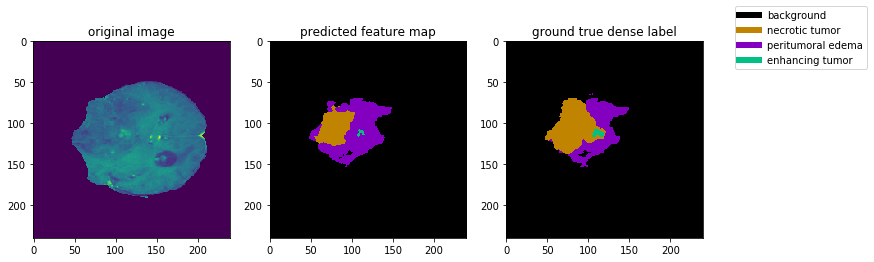

In [37]:
visualize(model_path='../UNet-ResidualBlock-Expansion_LGG_end_to_end/epoch10_model.pt',\
          device=device,
          base_path='BRATS2018/SEG_LGG/val/', img_name='Brats18_TCIA13_633_1_066')
torch.cuda.empty_cache()

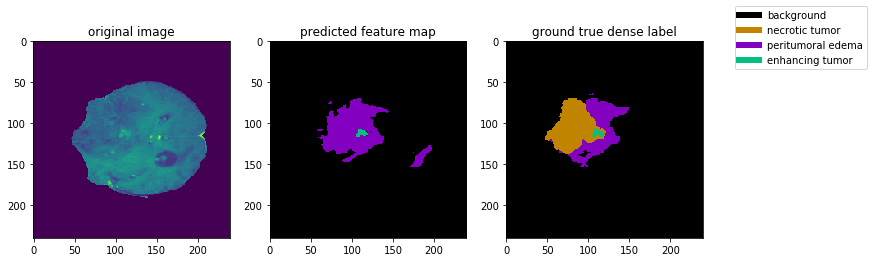

In [40]:
visualize(model_path='../UNet-ResidualBlock-Expansion_210_end_to_end_manual/UNet-ResidualBlock-Expansion-BRATS2018-End-to-End_batch6_training_epochs15_Adam_scheduler-step10-gamma1.0_lr5e-05_w_decay3e-05/trained_model.pt',
         device=device, base_path='BRATS2018/SEG_LGG/val/', img_name='Brats18_TCIA13_633_1_066')
torch.cuda.empty_cache()